# Finding the best split in a new dataset

We start by importing the data and then view a sample just to make sure it's all there. Our weapon of choice is numpy. The data consists of four columns: Subject ID, actigraph hours, self-report hours, and a difference score. Our variables of interest are the actigraph hours and self-report hours. Both these variables measure the time asleep in hours among 196 individuals, as measured by actigraph and a self-report questionnaire (PSQI) respectively. 

In [234]:
import numpy as np
np.set_printoptions(precision=2, suppress=True) # display 2 d.p.
data = np.genfromtxt('new_data.csv', delimiter=',', skip_header=1)
print("We have {} rows in the full data set.".format(data.shape[0]))
data = data[~np.isnan(data).any(axis=1)]
print("Checking for missing data. \
\nThere are {} rows in the checked data set".format(data.shape[0]))
#data[60:80,:].view()  # view a sample of records (lines 60 to 80)

We have 196 rows in the full data set.
Checking for missing data. 
There are 196 rows in the checked data set


#### Viewing the data  
Differences exist between our two variables of interest. To view these differences in more detail, we can use the magic of Seaborn (thanks Sam!).

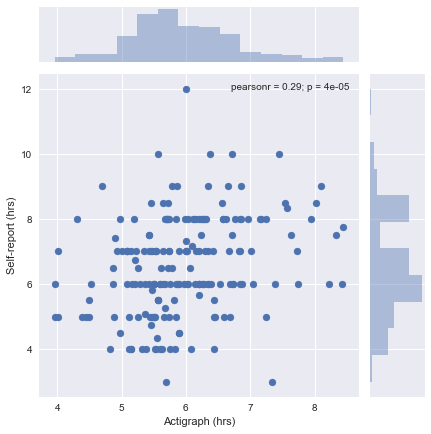

In [3]:
from scipy import stats, integrate
import matplotlib.pyplot as pl
import seaborn as ss
%matplotlib inline

x = data[:,1] # Actigraph hrs
y = data[:,2] # Self-report hrs

ss.set(color_codes=True)
ss.jointplot(x, y).set_axis_labels("Actigraph (hrs)", "Self-report (hrs)")
#ss.jointplot(x, y, kind="kde");

A simple scatterplot shows us the variables covary a little, but not a lot (i.e., **r = 0.29**). Finding a perfect tertiary split will be unlikely given the amount of unique variance in each dataset. 

#### Finding the best split
Our aim is to divide the data into tripartite divisions which result in three equivalent (but not equal) proportions in both data sets. In other words, the number of people in the lowest division of each dataset will be equal, and the number of people in the middle division of each dataset will be equal, and so on. 

Hence, we can define a cost function which represents the difference in proportions between datasets as 'error' or 'cost. Our aim is to minimize the 'cost' between data sets by carefully selecting our division thresholds.

The **split_costm** function includes an option to set a penalty in the top and bottom divisions (**delta**) in order to ensure the middle division is larger. Higher penalty values will result in smaller numbers in the top and bottom division.

Our default dataset (**d**) will be the z-score transformed variables rather than raw hours. This means the threshold (**params**) will be given in z-score units rather than hours (e.g., -1 and +1 z-score units)

In [4]:
# Add a z-score transform to the data
x_z = stats.zscore(x) # Actigraph z-scores
y_z = stats.zscore(y) # Self-report z-scores
d = np.asarray([x_z,y_z]).T # create an array
d.shape

(196, 2)

In [201]:
# define some helper functions
def crosstab(params, array=d):
    
    lb, ub = params
    row1 = array < lb
    row2 = (array > lb) & (array < ub)
    row3 = array > ub
    
    m = np.mat(np.zeros((3,3)))
    m[0,] = np.array([sum(row1.all(axis=1)), 
                    sum(np.array([row1[:,0], row2[:,1]]).all(axis=0)), 
                    sum(np.array([row1[:,0], row3[:,1]]).all(axis=0))])
    
    m[1,] = np.array([sum(np.array([row2[:,0], row1[:,1]]).all(axis=0)), 
                    sum(row2.all(axis=1)), 
                    sum(np.array([row2[:,0], row3[:,1]]).all(axis=0))])
    
    m[2,] = np.array([sum(np.array([row3[:,0], row1[:,1]]).all(axis=0)), 
                    sum(np.array([row3[:,0], row2[:,1]]).all(axis=0)), 
                    sum(row3.all(axis=1))])
    return m

def split_costm(params, delta = .05, array = d):
    
    m = crosstab(params, array)   
    m = m / m.sum()
    
    dmat = np.mat([[-delta,0,0],
               [0,2*delta,0],
               [0,0,-delta]])

    L = np.identity(3) / 3 + dmat
    
    cost = abs(L - m)
    
    return cost.sum()

split_costm(params)

0.99047619047619051

Our cost function tells us the total difference (in arbitrary units) between the two datasets with the given parameters (-1 and +1).

At this point it is worth taking a look at the cost function. Given the small nature of the parameter space and the low dimensional dataset (2D), we can easily visualize the cost function in 3 dimensions. What we are hoping to see is a smooth, convex function.

Mapping parameter space... Done


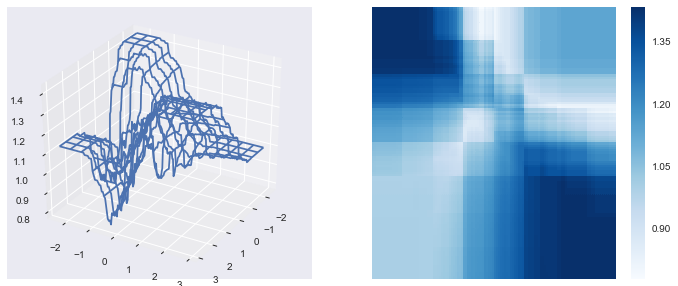

In [202]:
from mpl_toolkits.mplot3d import axes3d

lower_bound = max(x_z.min(),y_z.min()) # lower boundary of our param space
upper_bound = min(x_z.max(),y_z.max()) # upper boundary of our param space

# Initialising x- and y-dimensions of our param space
xx = np.linspace(lower_bound,upper_bound,num=120)
yy = np.linspace(lower_bound,upper_bound,num=120)
Z = np.empty([len(xx),len(yy)])
                    
# finding the cost over our param space (i.e., z-dimension)
print('Mapping parameter space...',end='')
for row,i in enumerate(xx):
    for col,j in enumerate(yy):
        Z[row,col] = split_costm(params=[i,j]) # cost over param space

print(' Done')

# Plotting x, y and z
%matplotlib inline
X = np.tile(xx,(120,1))
Y = np.tile(yy,(120,1))
Y = Y.T

fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.view_init(30,30)

ax = fig.add_subplot(122)
ax = ss.heatmap(Z, cmap="Blues", xticklabels=False, yticklabels=False)
pl.show()

The 3D left plot shows the parameter space in x, y and z dimensions. Cost is height (z-dimension). It is a fairly smooth function, but it is not convex and may contain many local minima. The right plot shows a 2D top-down view of the 3D plot - peaks are blue (highest cost > 40), valleys are white (lowest cost = 0). There doesn't appear to be many (any?) points in our param space with zero cost.

In [205]:
from scipy.optimize import optimize
result = np.asarray([0,0])
result = result.reshape(1,2)
xdim = np.linspace(-1.28, 1.28, num=10)
ydim = np.linspace(-1.28, 1.28, num=10)
print('Searching parameter space...', end='')
for i in xdim:
    for j in ydim:
        minimum = optimize.fmin(split_costm, x0=([i,j]), disp=0)
        if split_costm(minimum) < 1 and (minimum[0] < minimum[1]):
            result = np.append(result,minimum.reshape(1,2), axis = 0)
print(' Done')

result
#minimum = optimize.fmin(split_cost,[6,8])

Searching parameter space... Done


array([[ 0.  ,  0.  ],
       [-1.28,  0.43],
       [-1.28,  0.68],
       [-1.05,  0.43],
       [-1.05,  0.68],
       [-0.67,  1.04],
       [-0.37,  1.83],
       [-0.71,  1.  ],
       [-0.75,  1.15],
       [-0.45,  1.1 ],
       [-0.44,  1.44],
       [-0.14,  0.14],
       [ 0.14,  0.16],
       [-0.37,  2.1 ],
       [-0.11,  0.21],
       [ 0.15,  0.2 ],
       [-0.14, -0.07],
       [-0.03,  0.2 ]])

In [226]:
# Check one of the solutions:
lb, ub = result[6,] #6
print('Cost of', lb,'and', ub, 'is', split_costm([lb, ub]),'\n')

# Convert to hours
print('Converting these z-scores back to hours, we have:')
hours = {'Act_low': round(lb*np.std(x) + np.mean(x),2)}
hours['PSQI_low'] = round(lb*np.std(y) + np.mean(y),2)
hours['Act_high'] = round(ub*np.std(x) + np.mean(x),2)
hours['PSQI_high'] = round(ub*np.std(y) + np.mean(x),2)
print('Thresholds for actigraph are', hours['Act_low'], 'and', hours['Act_high'],'hours')
print('Thresholds for PSQI are', hours['PSQI_low'], 'and', hours['PSQI_high'],'hours')

crosstab([lb,ub])

Cost of -0.367111111111 and 1.831 is 0.806802721088 

Converting these z-scores back to hours, we have:
Thresholds for actigraph are 5.64 and 7.52 hours
Thresholds for PSQI are 6.0 and 8.7 hours


matrix([[ 32.,  42.,   1.],
        [ 20.,  85.,   4.],
        [  0.,  12.,   0.]])

### Conclusion (to be continued)
With the given parameters, we could not find a local minima = 0. However there are multiple local minima in our cost function which represents splits that maximize the equivalence between our two variables of interest: actigraph hours and self-report hours. **More work needs to be done to optimize the cost function and explore whether different optimization functions in scikit-learn could provide a better result.**